In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.utils import shuffle
from scipy.stats import skew
from __future__ import division
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler
import gc
from math import sqrt

from sklearn import decomposition
from sklearn.decomposition import TruncatedSVD
from sklearn import cluster, metrics
from sklearn.cluster import MiniBatchKMeans
from sklearn.manifold import TSNE

from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import lightgbm as lgb
#from mlxtend.regressor import StackingRegressor

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
path = '../input/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')

# 1. Exploratory

In [3]:
train.shape

(4459, 4993)

In [4]:
test.shape

(49342, 4992)

In [5]:
train.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


In [6]:
#Save the 'Id' column
train_ID = train['ID']
test_ID = test['ID']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("ID", axis = 1, inplace = True)
test.drop("ID", axis = 1, inplace = True)

# 2. Cleaning

In [7]:
gc.collect()

18

In [8]:
y_train = train.target.values
train.drop(["target"], axis = 1, inplace = True)

In [9]:
only_one = train.columns[train.nunique() == 1]

In [10]:
train.drop(only_one, axis = 1, inplace = True)
test.drop(only_one, axis = 1, inplace = True)

In [11]:
train.head()

,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,dc5a8f1d8,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,0.0,0,0.0,0,0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,0.0,0,0.0,0,0,0,0,0,2200000.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0.0,0,0.0,0,0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0.0,0,0.0,0,0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,0.0,0,0.0,0,0,0,0,0,2000000.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


# 3. Feature Engineering / Feature selection

## 3.1 Feature engineering

In [12]:
def get_selected_features():
    return ['f190486d6',
 '58e2e02e6',
 '9fd594eec',
 'eeb9cd3aa',
 '6eef030c1',
 '20aa07010',
 '58232a6fb',
 '2087ed398',
 'ced6a7e91',
 '15ace8c9f',
 'fb387ea33',
 'b43a7cfd5',
 '402b0d650',
 'f514fdb2e',
 '371ff7a11',
 '58e056e12',
 '1702b5bf0',
 '2c6c62b54',
 '5f341a818',
 'bb1113dbb',
 'fb0f5dbfe',
 'df838756c',
 '2288333b4',
 '1d9078f84',
 'f32763afc',
 '0bb96a2ae',
 'bf6e38e39',
 '37f57824c',
 '64e483341',
 '5b714cd7a',
 '9f7b782ac',
 '5a798adc1',
 'ab7764ead',
 'd6bb78916',
 'f74e8f13d',
 'c089837ee',
 'c47340d97',
 '43782ef36',
 '98af380ad',
 '58ed8fb53',
 'b9ba17eb6',
 'f41af7c85',
 'ba4ceabc5',
 '4edc3388d',
 '26ab20ff9',
 'b30e932ba']

### 3.1.0 Target as a label

Reference: https://www.kaggle.com/prashantkikani/santad-label-is-present-in-row

In [13]:
target = y_train
trainnp = np.array(train)
target1 = np.array([target[i] in trainnp[i] for i in range(trainnp.shape[0])]).astype(np.int)

In [14]:
print(len(target1[target1 == 0]))  # 2887

2887


In [15]:
print(len(target1[target1 == 1]))  # 1572

1572


In [16]:
def add_statistics(train, test):
    train_zeros = pd.DataFrame({'Percent_zero': ((train.values) == 0).mean(axis=0),
                                'Column': train.columns})
    
    high_vol_columns = train_zeros['Column'][train_zeros['Percent_zero'] < 0.70].values
    low_vol_columns = train_zeros['Column'][train_zeros['Percent_zero'] >= 0.70].values
    #This is part of the trick I think, plus lightgbm has a special process for NaNs
    train = train.replace({0:np.nan})
    test = test.replace({0:np.nan})

    cluster_sets = {"low":low_vol_columns, "high":high_vol_columns}
    for cluster_key in cluster_sets:
        # print(cluster_key)
        for df in [train,test]:
            # print(df)
            df["count_not0_"+cluster_key] = df[cluster_sets[cluster_key]].count(axis=1)
            df["sum_"+cluster_key] = df[cluster_sets[cluster_key]].sum(axis=1)
            df["var_"+cluster_key] = df[cluster_sets[cluster_key]].var(axis=1)
            df["median_"+cluster_key] = df[cluster_sets[cluster_key]].median(axis=1)
            df["mean_"+cluster_key] = df[cluster_sets[cluster_key]].mean(axis=1)
            df["std_"+cluster_key] = df[cluster_sets[cluster_key]].std(axis=1)
            df["max_"+cluster_key] = df[cluster_sets[cluster_key]].max(axis=1)
            df["min_"+cluster_key] = df[cluster_sets[cluster_key]].min(axis=1)
            df["skew_"+cluster_key] = df[cluster_sets[cluster_key]].skew(axis=1)
            df["kurtosis_"+cluster_key] = df[cluster_sets[cluster_key]].kurtosis(axis=1)
    train_more_simplified = train.drop(high_vol_columns,axis=1).drop(low_vol_columns,axis=1)
    test_more_simplified = test.drop(high_vol_columns,axis=1).drop(low_vol_columns,axis=1)
    # colnames = list(train_more_simplified)
    return train_more_simplified, test_more_simplified
    
train1, test1 = add_statistics(train, test)
train1 = np.log1p(train1)
test1 = np.log1p(test1)

lgb_params = {
        'objective': 'binary',
        'num_leaves': 60,
        'subsample': 0.6143,
        'colsample_bytree': 0.6453,
        'min_split_gain': np.power(10, -2.5988),
        'reg_alpha': np.power(10, -2.2887),
        'reg_lambda': np.power(10, 1.7570),
        'min_child_weight': np.power(10, -0.1477),
        'verbose': -1,
        'seed': 3,
        'boosting_type': 'gbdt',
        'max_depth': -1,
        'learning_rate': 0.05,  # 0.05
        'metric': 'rmse',
    }
    
folds = KFold(n_splits=5, shuffle=True, random_state=1)

dtrain = lgb.Dataset(data=train1, label=target1, free_raw_data=False)
sub_preds = np.zeros(test1.shape[0])
oof_preds = np.zeros(train1.shape[0])

for trn_idx, val_idx in folds.split(train1):
        # Train lightgbm
        clf = lgb.train(
            params=lgb_params,
            train_set=dtrain.subset(trn_idx),
            valid_sets=dtrain.subset(val_idx),
            num_boost_round=10000,
            early_stopping_rounds=100,
            verbose_eval=50
        )
        oof_preds[val_idx] = clf.predict(dtrain.data.iloc[val_idx])
        sub_preds += clf.predict(test1) / folds.n_splits
        
train["is_label"] = target1
# test["is_label"] = sub_preds

x = []
for i in sub_preds:
    if i <= (1572 / (2887 + 1572)):
        x.append(0)
    else:
        x.append(1)
test["is_label"] = x

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's rmse: 0.450394
[100]	valid_0's rmse: 0.443392
[150]	valid_0's rmse: 0.440039
[200]	valid_0's rmse: 0.439829
[250]	valid_0's rmse: 0.44094
Early stopping, best iteration is:
[167]	valid_0's rmse: 0.439504
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's rmse: 0.453537
[100]	valid_0's rmse: 0.450314
[150]	valid_0's rmse: 0.450384
[200]	valid_0's rmse: 0.451005
Early stopping, best iteration is:
[125]	valid_0's rmse: 0.44972
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's rmse: 0.444877
[100]	valid_0's rmse: 0.438501
[150]	valid_0's rmse: 0.437134
[200]	valid_0's rmse: 0.437645
Early stopping, best iteration is:
[138]	valid_0's rmse: 0.43672
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's rmse: 0.447155
[100]	valid_0's rmse: 0.441637
[150]	valid_0's rmse: 0.439888
[200]	valid_0's rmse: 0.440219
[250]	valid_0's rmse: 0.441241

In [17]:
gc.enable()
gc.collect()

347

In [18]:
y_train = np.log1p(y_train)

In [19]:
def add_statistics(train, test):
    train_zeros = pd.DataFrame({'Percent_zero': ((train.values) == 0).mean(axis=0),
                                'Column': train.columns})
    
    high_vol_columns = train_zeros['Column'][train_zeros['Percent_zero'] < 0.70].values
    low_vol_columns = train_zeros['Column'][train_zeros['Percent_zero'] >= 0.70].values
    #This is part of the trick I think, plus lightgbm has a special process for NaNs
    train = train.replace({0:np.nan})
    test = test.replace({0:np.nan})

    cluster_sets = {"low":low_vol_columns, "high":high_vol_columns}
    for cluster_key in cluster_sets:
        for df in [train,test]:
            df["count_not0_"+cluster_key] = df[cluster_sets[cluster_key]].count(axis=1)
            df["sum_"+cluster_key] = df[cluster_sets[cluster_key]].sum(axis=1)
            df["var_"+cluster_key] = df[cluster_sets[cluster_key]].var(axis=1)
            df["median_"+cluster_key] = df[cluster_sets[cluster_key]].median(axis=1)
            df["mean_"+cluster_key] = df[cluster_sets[cluster_key]].mean(axis=1)
            df["std_"+cluster_key] = df[cluster_sets[cluster_key]].std(axis=1)
            df["max_"+cluster_key] = df[cluster_sets[cluster_key]].max(axis=1)
            df["min_"+cluster_key] = df[cluster_sets[cluster_key]].min(axis=1)
            df["skew_"+cluster_key] = df[cluster_sets[cluster_key]].skew(axis=1)
            df["kurtosis_"+cluster_key] = df[cluster_sets[cluster_key]].kurtosis(axis=1)
    train_more_simplified = train.drop(high_vol_columns,axis=1).drop(low_vol_columns,axis=1)
    colnames = list(train_more_simplified)
    return train, test, colnames
    
data, test, colnames = add_statistics(train, test)
test["is_label"] = sub_preds
data["is_label"] = target1

In [20]:
colnames

['count_not0_low',
 'sum_low',
 'var_low',
 'median_low',
 'mean_low',
 'std_low',
 'max_low',
 'min_low',
 'skew_low',
 'kurtosis_low',
 'count_not0_high',
 'sum_high',
 'var_high',
 'median_high',
 'mean_high',
 'std_high',
 'max_high',
 'min_high',
 'skew_high',
 'kurtosis_high']

### 3.1.3 Clustering

TBD

### 3.1.4 Add temporal features

Based on: https://www.kaggle.com/hmendonca/kerasregressor-base

In [21]:
def moving_avg(df, prefix, win_size):
    print('Creating rolling average on {} columns'.format(win_size))
    ts = df.T.rolling(win_size*2, min_periods=1, center=True).mean().iloc[ win_size//2 : : win_size ].T # rolling average
    ts.columns = [prefix+str(n) for n in ts.columns]
    return ts

def moving_max(df, prefix, win_size):
    print('Creating rolling max on {} columns'.format(win_size))
    ts = df.T.rolling(win_size*2, min_periods=1, center=True).max().iloc[ win_size//2 : : win_size ].T # rolling max
    ts.columns = [prefix+str(n) for n in ts.columns]
    return ts

In [22]:
def compute_temporal_feature(df):
    # yearly, quartally, monthly, weekly, daily mean
    X = moving_avg(df, 'y_', 365)
    X = pd.concat([X, moving_avg(df, 'q_', 91)], axis=1)
    X = pd.concat([X, moving_avg(df, 'm_', 30)], axis=1)
    X = pd.concat([X, moving_avg(df, 'd_', 7)], axis=1)
    #  ... and max
    X = pd.concat([X, moving_max(df, 'ym_', 365)], axis=1)
    X = pd.concat([X, moving_max(df, 'qm_', 91)], axis=1)
    X = pd.concat([X, moving_max(df, 'mm_', 30)], axis=1)
    X = pd.concat([X, moving_max(df, 'dm_', 7)], axis=1)
    X = np.log1p(X)
    return X

In [23]:
gc.collect()

169

In [24]:
train_origin = pd.read_csv(path + 'train.csv')
test_origin = pd.read_csv(path + 'test.csv')
train_origin.drop(["ID", "target"], axis = 1, inplace = True)

In [25]:
test_origin.drop(["ID"], axis = 1, inplace = True)

In [26]:
col_origin = test_origin.columns
col_origin

Index(['48df886f9', '0deb4b6a8', '34b15f335', 'a8cb14b00', '2f0771a37',
       '30347e683', 'd08d1fbe3', '6ee66e115', '20aa07010', 'dc5a8f1d8',
       ...
       '3ecc09859', '9281abeea', '8675bec0b', '3a13ed79a', 'f677d4d13',
       '71b203550', '137efaa80', 'fb36b89d9', '7e293fbaf', '9fc776466'],
      dtype='object', length=4991)

In [27]:
%%time
train_origin = pd.concat([train_origin, compute_temporal_feature(train_origin)], axis=1)

Creating rolling average on 365 columns
Creating rolling average on 91 columns
Creating rolling average on 30 columns
Creating rolling average on 7 columns
Creating rolling max on 365 columns
Creating rolling max on 91 columns
Creating rolling max on 30 columns
Creating rolling max on 7 columns
Wall time: 14.3 s


In [28]:
%%time
test_origin = pd.concat([test_origin, compute_temporal_feature(test_origin)], axis=1)

Creating rolling average on 365 columns
Creating rolling average on 91 columns
Creating rolling average on 30 columns
Creating rolling average on 7 columns
Creating rolling max on 365 columns
Creating rolling max on 91 columns
Creating rolling max on 30 columns
Creating rolling max on 7 columns
Wall time: 2min 27s


In [29]:
colnames2 = list(train_origin.columns[len(col_origin):])
len(colnames2)

1896

In [30]:
gc.collect()

28

In [31]:
data_copy = data.copy(deep=True)
test_copy = test.copy(deep=True)

In [32]:
data = pd.concat([data, train_origin[colnames2]], axis=1)
test = pd.concat([test, test_origin[colnames2]], axis=1)

In [33]:
data.shape

(4459, 6652)

In [34]:
test.shape

(49342, 6652)

# 4. Modelisation

In [35]:
def rmse(y_test, y_pred):
    return sqrt(mean_squared_error(y_pred, y_test))

rmse_scorer = make_scorer(rmse)

In [36]:
train_leak = pd.read_csv(path + 'train_leak.csv')
data['leak'] = train_leak['compiled_leak']

test_leak = pd.read_csv(path + 'test_leak.csv')
test['leak'] = test_leak['compiled_leak']

In [190]:
from sklearn.preprocessing import MinMaxScaler
features = get_selected_features() + colnames #+ [col for col in colnames2 if not col.find('y_')] + ['leak']
Y = y_train
X_train = data[features].as_matrix()
X_test = test[features].as_matrix()


where_are_NaNs = np.isnan(X_train)
X_train[where_are_NaNs] = 0
where_are_NaNs = np.isnan(X_test)
X_test[where_are_NaNs] = 0
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [41]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [42]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=300,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
score = rmsle_cv(model_xgb)
score.mean()

0.6822853673539753

In [43]:
params = {
          'objective':'regression',
          'num_leaves':15,
          'learning_rate':0.05, 
          'n_estimators':300,
          'max_bin':55, 
          'bagging_fraction':0.8,
          'bagging_freq':7, 
          'feature_fraction':0.22,
          'feature_fraction_seed':9, 
          'bagging_seed':9,
          'min_data_in_leaf':4,
          'min_sum_hessian_in_leaf':10,
          'zero_as_missing':True
    }
model_lgb = lgb.LGBMRegressor(**params)
score = rmsle_cv(model_lgb)
score.mean()

0.7244392746610443

In [46]:
from mlxtend.regressor import StackingRegressor
from sklearn.svm import SVR
stregr = StackingRegressor(regressors=[model_lgb, model_xgb], 
                           meta_regressor=RandomForestRegressor(n_estimators=300))

score = rmsle_cv(stregr)
score.mean()

0.7696115667213832

Based on: https://www.kaggle.com/ogrellier/santander-46-features

In [102]:
len(features)

81

In [ ]:
# define wider model
def wider_model():
    # create model
    model = Sequential()
    
    model.add(Dense(100, input_dim=len(features), kernel_initializer='normal', activation='relu'))
    #model.add(Dropout(rate = 0.2))
    model.add(Dense(units = 100, kernel_initializer = "uniform", activation = "relu"))
    #model.add(Dropout(rate = 0.2))
    
    #model.add(Dense(units = 1, kernel_initializer = "uniform", activation = "linear"))
    #model.add(Dense(units=256, input_dim=len(features), init='uniform', activation='relu'))
    #model.add(Dense(units=256, activation='relu'))
    #model.add(Dense(units=256, activation='relu'))
    model.add(Dense(units = 1, kernel_initializer = "uniform", activation = "linear"))
    
    # Compile model
    model.compile(optimizer = optimizers.sgd(lr=0.1), loss = root_mean_squared_error, 
              metrics =["accuracy"])
    return model


In [ ]:
# define wider model
def wider_model():
    # create model
    model = Sequential()
    
    #model.add(Dense(256, input_dim=len(features), kernel_initializer='normal', activation='relu'))
    #model.add(Dense(units = 128, kernel_initializer = "uniform", activation = "relu"))
    #model.add(Dense(units = 64, kernel_initializer = "uniform", activation = "relu"))
    #model.add(Dense(units = 32, kernel_initializer = "uniform", activation = "relu"))
    model.add(Dense(80, input_dim=len(features)))
    model.add( Activation( "relu" ) )
    model.add( Dense( 80 ) )
    model.add( Activation( "relu" ) )
    model.add( Dense( 1 ) )
    #model.add(Dense(units = 1, kernel_initializer = "uniform", activation = "linear"))
    
    # Compile model
    model.compile(optimizer = optimizers.sgd(lr=0.05), loss = root_mean_squared_error, 
              metrics =["accuracy"])
    return model

model = KerasRegressor(build_fn=wider_model, epochs=100, batch_size=20)

Train on 3567 samples, validate on 892 samples
Epoch 1/60
 - 8s - loss: 89.3330 - root_mean_squared_error: 8.6898 - val_loss: 16.5088 - val_root_mean_squared_error: 3.6091
Epoch 2/60
 - 1s - loss: 6.5821 - root_mean_squared_error: 2.0949 - val_loss: 2.7339 - val_root_mean_squared_error: 1.3853
Epoch 3/60
 - 1s - loss: 2.8233 - root_mean_squared_error: 1.3851 - val_loss: 2.2346 - val_root_mean_squared_error: 1.2241
Epoch 4/60
 - 1s - loss: 2.5229 - root_mean_squared_error: 1.2891 - val_loss: 2.0854 - val_root_mean_squared_error: 1.1668
Epoch 5/60
 - 1s - loss: 2.4047 - root_mean_squared_error: 1.2546 - val_loss: 2.0191 - val_root_mean_squared_error: 1.1425
Epoch 6/60
 - 1s - loss: 2.2993 - root_mean_squared_error: 1.2295 - val_loss: 1.9942 - val_root_mean_squared_error: 1.1286
Epoch 7/60
 - 1s - loss: 2.2708 - root_mean_squared_error: 1.2174 - val_loss: 1.9699 - val_root_mean_squared_error: 1.1167
Epoch 8/60
 - 1s - loss: 2.1820 - root_mean_squared_error: 1.1848 - val_loss: 1.9521 - val

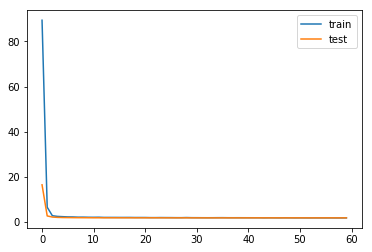

In [198]:
seed = 7
np.random.seed(seed)

train_X = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
train_X, test_X, train_y, test_y = train_test_split(train_X, y_train, train_size=0.8, random_state=seed)

model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mse', optimizer=optimizers.sgd(lr=0.05), metrics=[root_mean_squared_error])
# fit network
history = model.fit(train_X, train_y, epochs=60, batch_size=80, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [199]:
res = model.predict(test_X)
mean_squared_error(test_y, res[:,0]) ** .5

1.3699330003846704

In [148]:
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation, BatchNormalization
from keras import optimizers
from keras import backend as K
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostRegressor
from keras import losses
from keras.layers import Embedding,LSTM

'''
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

def root_mean_squared_error(y_true, y_pred):
        #return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))
        return K.sqrt(losses.mean_squared_error(y_true, y_pred))
    
# define wider model
def wider_model():
    # create model
    model = Sequential()    
    model.add(Dense(128, input_dim=len(features), kernel_initializer='normal', activation='relu'))
    model.add( Dense( 1 ) )
    model.compile(optimizer = optimizers.sgd(lr=0.05), loss = root_mean_squared_error, 
              metrics =["accuracy"])
    return model

estimators = KerasRegressor(build_fn=wider_model, epochs=100, batch_size=10)

results = rmsle_cv(estimators)
print("Wider: %.2f (%.2f) MSE" % (results.mean(), results.std()))
'''

'\n# fix random seed for reproducibility\nseed = 7\nnp.random.seed(seed)\n\ndef root_mean_squared_error(y_true, y_pred):\n        #return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))\n        return K.sqrt(losses.mean_squared_error(y_true, y_pred))\n    \n# define wider model\ndef wider_model():\n    # create model\n    model = Sequential()    \n    model.add(Dense(128, input_dim=len(features), kernel_initializer=\'normal\', activation=\'relu\'))\n    model.add( Dense( 1 ) )\n    model.compile(optimizer = optimizers.sgd(lr=0.05), loss = root_mean_squared_error, \n              metrics =["accuracy"])\n    return model\n\nestimators = KerasRegressor(build_fn=wider_model, epochs=100, batch_size=10)\n\nresults = rmsle_cv(estimators)\nprint("Wider: %.2f (%.2f) MSE" % (results.mean(), results.std()))\n'

In [201]:
def get_rnn(train):
    seed = 7
    np.random.seed(seed)
    train_X = X_train.reshape((train.shape[0], 1, train.shape[1]))
    model = Sequential()
    model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer=optimizers.sgd(lr=0.05), metrics=[root_mean_squared_error])
    return model

def fit_predict_rnn(train, y_train, test):
    # Create folds
    folds = KFold(n_splits=10, shuffle=True, random_state=1) 
    # Init predictions
    sub_preds = np.zeros(test.shape[0])
    oof_preds = np.zeros(train.shape[0])
    test = test.reshape((test.shape[0], 1, test.shape[1]))
    # Run KFold
    for trn_idx, val_idx in folds.split(train):
        # Predict Out Of Fold and Test targets
        model = get_rnn(train)
        train_X = train[trn_idx].reshape((train[trn_idx].shape[0], 1, train[trn_idx].shape[1]))
        test_X = train[val_idx].reshape((train[val_idx].shape[0], 1, train[val_idx].shape[1]))
        model.fit(train_X, y_train[trn_idx], epochs=50, batch_size=10, validation_data=(test_X, y_train[val_idx]), verbose=2, shuffle=False)
        # Using lgb.train, predict will automatically select the best round for prediction
        oof_preds[val_idx] = model.predict(test_X)[:,0]
        sub_preds += model.predict(test)[:,0] / folds.n_splits
        # Display current fold score
        print(mean_squared_error(y_train[val_idx], 
                                 oof_preds[val_idx]) ** .5)
    # Display Full OOF score (square root of a sum is not the sum of square roots)
    print('Full Out-Of-Fold score : %9.6f' 
          % (mean_squared_error(y_train, oof_preds) ** .5))

    return oof_preds, sub_preds

seed = 7
np.random.seed(seed)
oof_preds_rnn, sub_preds_rnn = fit_predict_rnn(X_train, y_train, X_test)

Train on 4013 samples, validate on 446 samples
Epoch 1/50
 - 11s - loss: 4.7960 - root_mean_squared_error: 1.4554 - val_loss: 1.8046 - val_root_mean_squared_error: 1.0752
Epoch 2/50
 - 4s - loss: 2.0758 - root_mean_squared_error: 1.1461 - val_loss: 1.7128 - val_root_mean_squared_error: 1.0442
Epoch 3/50
 - 4s - loss: 1.9813 - root_mean_squared_error: 1.1127 - val_loss: 1.7224 - val_root_mean_squared_error: 1.0445
Epoch 4/50
 - 4s - loss: 1.9186 - root_mean_squared_error: 1.0955 - val_loss: 1.7267 - val_root_mean_squared_error: 1.0437
Epoch 5/50
 - 4s - loss: 1.8585 - root_mean_squared_error: 1.0762 - val_loss: 1.7050 - val_root_mean_squared_error: 1.0370
Epoch 6/50
 - 4s - loss: 1.8382 - root_mean_squared_error: 1.0667 - val_loss: 1.7130 - val_root_mean_squared_error: 1.0465
Epoch 7/50
 - 5s - loss: 1.8126 - root_mean_squared_error: 1.0580 - val_loss: 1.6834 - val_root_mean_squared_error: 1.0313
Epoch 8/50
 - 5s - loss: 1.7818 - root_mean_squared_error: 1.0421 - val_loss: 1.6995 - val_

Epoch 17/50
 - 6s - loss: 1.6102 - root_mean_squared_error: 0.9854 - val_loss: 2.0839 - val_root_mean_squared_error: 1.1391
Epoch 18/50
 - 5s - loss: 1.5926 - root_mean_squared_error: 0.9818 - val_loss: 2.0922 - val_root_mean_squared_error: 1.1432
Epoch 19/50
 - 6s - loss: 1.5814 - root_mean_squared_error: 0.9787 - val_loss: 2.0979 - val_root_mean_squared_error: 1.1393
Epoch 20/50
 - 5s - loss: 1.5621 - root_mean_squared_error: 0.9740 - val_loss: 2.0447 - val_root_mean_squared_error: 1.1281
Epoch 21/50
 - 5s - loss: 1.5521 - root_mean_squared_error: 0.9701 - val_loss: 2.0357 - val_root_mean_squared_error: 1.1281
Epoch 22/50
 - 7s - loss: 1.5373 - root_mean_squared_error: 0.9636 - val_loss: 2.1088 - val_root_mean_squared_error: 1.1362
Epoch 23/50
 - 5s - loss: 1.5339 - root_mean_squared_error: 0.9575 - val_loss: 2.0975 - val_root_mean_squared_error: 1.1372
Epoch 24/50
 - 5s - loss: 1.5183 - root_mean_squared_error: 0.9591 - val_loss: 2.0634 - val_root_mean_squared_error: 1.1288
Epoch 25

Epoch 33/50
 - 6s - loss: 1.3975 - root_mean_squared_error: 0.9089 - val_loss: 2.4021 - val_root_mean_squared_error: 1.2227
Epoch 34/50
 - 10s - loss: 1.3944 - root_mean_squared_error: 0.9136 - val_loss: 2.3697 - val_root_mean_squared_error: 1.2076
Epoch 35/50
 - 10s - loss: 1.3912 - root_mean_squared_error: 0.9137 - val_loss: 2.4275 - val_root_mean_squared_error: 1.2240
Epoch 36/50
 - 6s - loss: 1.3757 - root_mean_squared_error: 0.9049 - val_loss: 2.4119 - val_root_mean_squared_error: 1.2166
Epoch 37/50
 - 7s - loss: 1.3561 - root_mean_squared_error: 0.8986 - val_loss: 2.4122 - val_root_mean_squared_error: 1.2219
Epoch 38/50
 - 5s - loss: 1.3545 - root_mean_squared_error: 0.8999 - val_loss: 2.4651 - val_root_mean_squared_error: 1.2324
Epoch 39/50
 - 5s - loss: 1.3626 - root_mean_squared_error: 0.8966 - val_loss: 2.4507 - val_root_mean_squared_error: 1.2300
Epoch 40/50
 - 7s - loss: 1.3455 - root_mean_squared_error: 0.8926 - val_loss: 2.4519 - val_root_mean_squared_error: 1.2265
Epoch 

Epoch 49/50
 - 6s - loss: 1.3823 - root_mean_squared_error: 0.9040 - val_loss: 2.1561 - val_root_mean_squared_error: 1.1320
Epoch 50/50
 - 5s - loss: 1.3583 - root_mean_squared_error: 0.8888 - val_loss: 2.0721 - val_root_mean_squared_error: 1.1062
1.4394935300612095
Train on 4013 samples, validate on 446 samples
Epoch 1/50
 - 16s - loss: 4.7716 - root_mean_squared_error: 1.4540 - val_loss: 2.0497 - val_root_mean_squared_error: 1.1526
Epoch 2/50
 - 6s - loss: 2.0747 - root_mean_squared_error: 1.1454 - val_loss: 1.9763 - val_root_mean_squared_error: 1.1304
Epoch 3/50
 - 5s - loss: 1.9596 - root_mean_squared_error: 1.1086 - val_loss: 1.9196 - val_root_mean_squared_error: 1.1161
Epoch 4/50
 - 5s - loss: 1.8958 - root_mean_squared_error: 1.0871 - val_loss: 1.9132 - val_root_mean_squared_error: 1.1088
Epoch 5/50
 - 7s - loss: 1.8476 - root_mean_squared_error: 1.0709 - val_loss: 1.8991 - val_root_mean_squared_error: 1.1072
Epoch 6/50
 - 5s - loss: 1.8361 - root_mean_squared_error: 1.0653 - va

Epoch 15/50
 - 6s - loss: 1.6415 - root_mean_squared_error: 0.9962 - val_loss: 2.0100 - val_root_mean_squared_error: 1.1086
Epoch 16/50
 - 6s - loss: 1.6012 - root_mean_squared_error: 0.9794 - val_loss: 2.0286 - val_root_mean_squared_error: 1.1110
Epoch 17/50
 - 6s - loss: 1.5903 - root_mean_squared_error: 0.9773 - val_loss: 1.9900 - val_root_mean_squared_error: 1.1062
Epoch 18/50
 - 6s - loss: 1.5985 - root_mean_squared_error: 0.9815 - val_loss: 1.9980 - val_root_mean_squared_error: 1.1068
Epoch 19/50
 - 5s - loss: 1.5787 - root_mean_squared_error: 0.9793 - val_loss: 1.9465 - val_root_mean_squared_error: 1.0904
Epoch 20/50
 - 7s - loss: 1.5637 - root_mean_squared_error: 0.9644 - val_loss: 1.9701 - val_root_mean_squared_error: 1.0936
Epoch 21/50
 - 6s - loss: 1.5674 - root_mean_squared_error: 0.9716 - val_loss: 1.9503 - val_root_mean_squared_error: 1.1017
Epoch 22/50
 - 6s - loss: 1.5322 - root_mean_squared_error: 0.9586 - val_loss: 1.9564 - val_root_mean_squared_error: 1.0950
Epoch 23

Epoch 31/50
 - 6s - loss: 1.4871 - root_mean_squared_error: 0.9457 - val_loss: 1.7915 - val_root_mean_squared_error: 1.0315
Epoch 32/50
 - 7s - loss: 1.4742 - root_mean_squared_error: 0.9416 - val_loss: 1.8154 - val_root_mean_squared_error: 1.0323
Epoch 33/50
 - 5s - loss: 1.4452 - root_mean_squared_error: 0.9268 - val_loss: 1.8199 - val_root_mean_squared_error: 1.0369
Epoch 34/50
 - 6s - loss: 1.4702 - root_mean_squared_error: 0.9376 - val_loss: 1.8199 - val_root_mean_squared_error: 1.0435
Epoch 35/50
 - 7s - loss: 1.4491 - root_mean_squared_error: 0.9318 - val_loss: 1.8448 - val_root_mean_squared_error: 1.0446
Epoch 36/50
 - 5s - loss: 1.4425 - root_mean_squared_error: 0.9300 - val_loss: 1.8177 - val_root_mean_squared_error: 1.0313
Epoch 37/50
 - 6s - loss: 1.4434 - root_mean_squared_error: 0.9260 - val_loss: 1.8094 - val_root_mean_squared_error: 1.0336
Epoch 38/50
 - 6s - loss: 1.4002 - root_mean_squared_error: 0.9127 - val_loss: 1.8290 - val_root_mean_squared_error: 1.0380
Epoch 39

Epoch 47/50
 - 6s - loss: 1.3120 - root_mean_squared_error: 0.8809 - val_loss: 2.3758 - val_root_mean_squared_error: 1.2018
Epoch 48/50
 - 6s - loss: 1.3088 - root_mean_squared_error: 0.8794 - val_loss: 2.3806 - val_root_mean_squared_error: 1.2037
Epoch 49/50
 - 7s - loss: 1.3013 - root_mean_squared_error: 0.8702 - val_loss: 2.4159 - val_root_mean_squared_error: 1.2057
Epoch 50/50
 - 6s - loss: 1.3063 - root_mean_squared_error: 0.8746 - val_loss: 2.3637 - val_root_mean_squared_error: 1.1956
1.5374209860074635
Train on 4013 samples, validate on 446 samples
Epoch 1/50
 - 16s - loss: 4.7777 - root_mean_squared_error: 1.4437 - val_loss: 2.0437 - val_root_mean_squared_error: 1.1290
Epoch 2/50
 - 5s - loss: 2.0871 - root_mean_squared_error: 1.1481 - val_loss: 1.8655 - val_root_mean_squared_error: 1.0790
Epoch 3/50
 - 7s - loss: 1.9619 - root_mean_squared_error: 1.1059 - val_loss: 1.8773 - val_root_mean_squared_error: 1.0804
Epoch 4/50
 - 5s - loss: 1.9185 - root_mean_squared_error: 1.0958 - 

Epoch 13/50
 - 6s - loss: 1.7025 - root_mean_squared_error: 1.0201 - val_loss: 1.9198 - val_root_mean_squared_error: 1.0781
Epoch 14/50
 - 6s - loss: 1.6685 - root_mean_squared_error: 1.0050 - val_loss: 1.8715 - val_root_mean_squared_error: 1.0610
Epoch 15/50
 - 7s - loss: 1.6553 - root_mean_squared_error: 1.0085 - val_loss: 1.8872 - val_root_mean_squared_error: 1.0666
Epoch 16/50
 - 6s - loss: 1.6539 - root_mean_squared_error: 1.0041 - val_loss: 1.8921 - val_root_mean_squared_error: 1.0692
Epoch 17/50
 - 7s - loss: 1.6404 - root_mean_squared_error: 0.9966 - val_loss: 1.8905 - val_root_mean_squared_error: 1.0711
Epoch 18/50
 - 7s - loss: 1.6308 - root_mean_squared_error: 0.9942 - val_loss: 1.8948 - val_root_mean_squared_error: 1.0694
Epoch 19/50
 - 6s - loss: 1.6144 - root_mean_squared_error: 0.9910 - val_loss: 1.8695 - val_root_mean_squared_error: 1.0647
Epoch 20/50
 - 7s - loss: 1.6014 - root_mean_squared_error: 0.9854 - val_loss: 1.9267 - val_root_mean_squared_error: 1.0806
Epoch 21

In [202]:
def fit_predict_xgb(train, y_train, test):
    num_round = 1000
    early_stopping_rounds = 50
    dtest = xgb.DMatrix(test)
    # Create folds
    folds = KFold(n_splits=10, shuffle=True, random_state=1) 
    # Init predictions
    sub_preds = np.zeros(test.shape[0])
    oof_preds = np.zeros(train.shape[0])
    # Lightgbm parameters
    xgb_params = {
            'colsample_bytree':0.4603, 
            'gamma':0.0468, 
            'learning_rate':0.05,
            'max_depth':5, 
            'min_child_weight':1.7817, 
            'n_estimators':600,
            'reg_alpha':0.4640, 
            'reg_lambda':0.8571,
            'subsample':0.5213, 
            'silent':1,
            'random_state':7, 
            'nthread':-1,
            'zero_as_missing':True
    }
    # Run KFold
    for trn_idx, val_idx in folds.split(train):
        dtrain = xgb.DMatrix(train[trn_idx], y_train[trn_idx])
        dvalid = xgb.DMatrix(train[val_idx], y_train[val_idx])
        watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
        clf = xgb.train(xgb_params, dtrain, num_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        # Predict Out Of Fold and Test targets
        # Using lgb.train, predict will automatically select the best round for prediction
        oof_preds[val_idx] = clf.predict(dvalid)
        sub_preds += clf.predict(dtest) / folds.n_splits
        # Display current fold score
        print(mean_squared_error(y_train[val_idx], 
                                 oof_preds[val_idx]) ** .5)
    # Display Full OOF score (square root of a sum is not the sum of square roots)
    print('Full Out-Of-Fold score : %9.6f' 
          % (mean_squared_error(y_train, oof_preds) ** .5))

    return oof_preds, sub_preds

In [203]:
oof_preds_xgb, sub_preds_xgb = fit_predict_xgb(X_train, y_train, X_test)

1.2500310387222113
1.3566269341482236
1.4593475641910656
1.2943638883880424
1.290902774433465
1.366509597389377
1.2594645533780822
1.389805163118122
1.33853545017105
1.2923478091144696
Full Out-Of-Fold score :  1.331230


In [204]:
def fit_predict(train, y_train, test):
    # Create folds
    folds = KFold(n_splits=10, shuffle=True, random_state=1)
    # Convert to lightgbm Dataset
    dtrain = lgb.Dataset(data=train, label=y_train, free_raw_data=False)
    # Construct dataset so that we can use slice()
    dtrain.construct()
    # Init predictions
    sub_preds = np.zeros(test.shape[0])
    oof_preds = np.zeros(train.shape[0])
    # Lightgbm parameters
    lgb_params = {
          'objective':'regression',
          'num_leaves':15,
          'learning_rate':0.05, 
          'n_estimators':300,
          'max_bin':55, 
          'bagging_fraction':0.8,
          'bagging_freq':7, 
          'feature_fraction':0.22,
          'feature_fraction_seed':9, 
          'bagging_seed':9,
          'min_data_in_leaf':4,
          'min_sum_hessian_in_leaf':10,
          'zero_as_missing':True
    }
    # Run KFold
    for trn_idx, val_idx in folds.split(train):
        # Train lightgbm
        clf = lgb.train(
            params=lgb_params,
            train_set=dtrain.subset(trn_idx),
            valid_sets=dtrain.subset(val_idx),
            num_boost_round=10000, 
            early_stopping_rounds=100,
            verbose_eval=50
        )
        # Predict Out Of Fold and Test targets
        # Using lgb.train, predict will automatically select the best round for prediction
        oof_preds[val_idx] = clf.predict(dtrain.data[val_idx])
        sub_preds += clf.predict(test) / folds.n_splits
        # Display current fold score
        print(mean_squared_error(y_train[val_idx], 
                                 oof_preds[val_idx]) ** .5)
    # Display Full OOF score (square root of a sum is not the sum of square roots)
    print('Full Out-Of-Fold score : %9.6f' 
          % (mean_squared_error(y_train, oof_preds) ** .5))

    return oof_preds, sub_preds

In [205]:
oof_preds_lgb, sub_preds_lgb = fit_predict(X_train, y_train, X_test)

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 1.62313
[100]	valid_0's l2: 1.57671
[150]	valid_0's l2: 1.57859
[200]	valid_0's l2: 1.5717
[250]	valid_0's l2: 1.57179
[300]	valid_0's l2: 1.57898
Did not meet early stopping. Best iteration is:
[226]	valid_0's l2: 1.56445
1.2507805015553906
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 1.84992
[100]	valid_0's l2: 1.81495
[150]	valid_0's l2: 1.81163
[200]	valid_0's l2: 1.80824
[250]	valid_0's l2: 1.81028
[300]	valid_0's l2: 1.82797
Early stopping, best iteration is:
[235]	valid_0's l2: 1.80257
1.3425981349349767
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 2.13193
[100]	valid_0's l2: 2.12063
[150]	valid_0's l2: 2.11834
[200]	valid_0's l2: 2.11907
[250]	valid_0's l2: 2.11974
Early stopping, best iteration is:
[178]	valid_0's l2: 2.11034
1.4526997175860326
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2

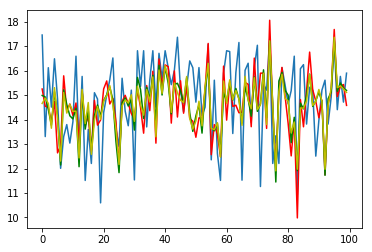

In [207]:
plt.plot(y_train[:100])
plt.plot(oof_preds_rnn[:100], color='r')
plt.plot(oof_preds_xgb[:100], color='g')
plt.plot(oof_preds_lgb[:100], color='y')

In [391]:
int_df = pd.DataFrame()
int_df['oof_preds_xgb'] = oof_preds_xgb
int_df['oof_preds_lgb'] = oof_preds_lgb
int_df['oof_preds_rnn'] = oof_preds_rnn
X_int = int_df[['oof_preds_xgb','oof_preds_lgb','oof_preds_rnn' ]].values

In [392]:
from sklearn import svm
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [393]:
model_xgb.fit(X_int, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4603, gamma=0.0468, learning_rate=0.05,
       max_delta_step=0, max_depth=3, min_child_weight=1.7817,
       missing=None, n_estimators=2200, n_jobs=1, nthread=-1,
       objective='reg:linear', random_state=7, reg_alpha=0.464,
       reg_lambda=0.8571, scale_pos_weight=1, seed=None, silent=1,
       subsample=0.5213)

In [394]:
oof_preds_cor = model_xgb.predict(X_int)
print('Full Out-Of-Fold score : %9.6f' 
      % (mean_squared_error(y_train, oof_preds_cor) ** .5))

Full Out-Of-Fold score :  1.029238


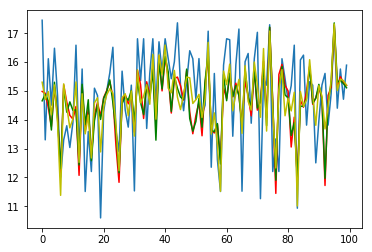

In [395]:
plt.plot(y_train[:100])
plt.plot(oof_preds_xgb[:100], color='r')
plt.plot(oof_preds_lgb[:100], color='g')
plt.plot(oof_preds_cor[:100], color='y')

In [396]:
# Linear combinaison between xgb/lgb and rnn
int_df = pd.DataFrame()
int_df['sub_preds_xgb'] = sub_preds_xgb
int_df['sub_preds_lgb'] = sub_preds_lgb
int_df['sub_preds_rnn'] = sub_preds_rnn
X_int = int_df[['sub_preds_xgb','sub_preds_lgb','sub_preds_rnn' ]].values
subs_preds_cor = model_xgb.predict(X_int)

In [ ]:
# LB: 0.64 - OOF Score: 1.318194 - Fixed Out-Of-Fold score :  1.423758
'''
model_xgb = LinearRegression()
'''

In [249]:
# LB: 0.66 - OOF Score: 1.029238 - Fixed Out-Of-Fold score :  1.494932
'''
 model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
'''

In [400]:
# LB: 0.64 - OOF Score: 1.318695 - Fixed Out-Of-Fold score :  1.424577
oof_preds_cor = 0.6*oof_preds_lgb + 0.3*oof_preds_xgb + 0.1*oof_preds_rnn
print('Full Out-Of-Fold score : %9.6f' 
      % (mean_squared_error(y_train, oof_preds_cor) ** .5))
subs_preds_cor = 0.6*sub_preds_lgb + 0.3*sub_preds_xgb + 0.1*sub_preds_rnn

Full Out-Of-Fold score :  1.318695


In [398]:
# LB: 0.64 - OOF Score: 1.319876 - Fixed Out-Of-Fold score :  1.424623
subs_preds_cor = sub_preds_lgb

In [401]:
test_leak = pd.read_csv(path + 'test_leak.csv')
test_leak = np.log1p(test_leak['compiled_leak'])
test_leak_null_index = test_leak.index[test_leak.apply(np.isnan)]
test_leak.dropna(inplace=True)

# 0.6 - 0.3 - 0.1: 1.424577
# 1.0 - 0.0 - 0.0: 1.424623
#subs_preds_cor = 1.0*sub_preds_lgb + 0.0*sub_preds_xgb + 0.0*sub_preds_rnn

subs_preds_cor_cor = np.delete(subs_preds_cor, test_leak_null_index)
subs_preds_cor_cor

print('Fixed Out-Of-Fold score : %9.6f' 
      % (mean_squared_error(test_leak, subs_preds_cor_cor) ** .5))

Fixed Out-Of-Fold score :  1.424577


# 5. Compile final result

In [358]:
res = pd.DataFrame()
res['ID'] =  test_ID
res['target'] = np.expm1(subs_preds_cor)

Use leak here: https://www.kaggle.com/johnfarrell/breaking-lb-fresh-start-with-lag-selection/output

In [359]:
#On recupere quelques predictions
test_leak = pd.read_csv(path + 'test_leak.csv')
test_leak = test_leak['compiled_leak']
test_leak.head(20)

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
5            NaN
6            NaN
7            NaN
8            NaN
9            NaN
10    20000000.0
11           NaN
12           NaN
13           NaN
14           NaN
15           NaN
16           NaN
17           NaN
18           NaN
19           NaN
Name: compiled_leak, dtype: float64

In [360]:
df = pd.concat([res, test_leak], axis=1)
df.head(20)

,ID,target,compiled_leak
0,000137c73,1.422627e+06,NaN
1,00021489f,1.127863e+06,NaN
2,0004d7953,1.795210e+06,NaN
3,00056a333,4.532136e+06,NaN
4,00056d8eb,1.545020e+06,NaN
5,0005fc190,1.580568e+06,NaN
6,000787e86,1.414879e+06,NaN
7,0008510a0,2.268253e+06,NaN
8,000895faf,2.847991e+06,NaN
9,000986fba,2.920343e+06,NaN


In [361]:
def correction(entry):
    if pd.isna(entry['compiled_leak']):
        return entry['target']
    else:
        return entry['compiled_leak']
df['target'] = df.apply(correction, axis=1)

In [362]:
df.head(20)

,ID,target,compiled_leak
0,000137c73,1.422627e+06,NaN
1,00021489f,1.127863e+06,NaN
2,0004d7953,1.795210e+06,NaN
3,00056a333,4.532136e+06,NaN
4,00056d8eb,1.545020e+06,NaN
5,0005fc190,1.580568e+06,NaN
6,000787e86,1.414879e+06,NaN
7,0008510a0,2.268253e+06,NaN
8,000895faf,2.847991e+06,NaN
9,000986fba,2.920343e+06,NaN


In [363]:
df.drop(['compiled_leak'], axis=1, inplace=True)
df.head(20)

,ID,target
0,000137c73,1.422627e+06
1,00021489f,1.127863e+06
2,0004d7953,1.795210e+06
3,00056a333,4.532136e+06
4,00056d8eb,1.545020e+06
5,0005fc190,1.580568e+06
6,000787e86,1.414879e+06
7,0008510a0,2.268253e+06
8,000895faf,2.847991e+06
9,000986fba,2.920343e+06


In [364]:
df.to_csv('submission-oof-lgm-83-py.csv', index=False)